In [37]:

import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import kagglehub
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
import kagglehub

ravdess = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
crema   = kagglehub.dataset_download("ejlok1/cremad")
tess    = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
savee   = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

print(ravdess, crema, tess, savee)


C:\Users\anagh\.cache\kagglehub\datasets\uwrfkaggler\ravdess-emotional-speech-audio\versions\1 C:\Users\anagh\.cache\kagglehub\datasets\ejlok1\cremad\versions\1 C:\Users\anagh\.cache\kagglehub\datasets\ejlok1\toronto-emotional-speech-set-tess\versions\1 C:\Users\anagh\.cache\kagglehub\datasets\ejlok1\surrey-audiovisual-expressed-emotion-savee\versions\1


In [13]:
ravdess_map = {
    '01':'neutral','02':'calm','03':'happy','04':'sad',
    '05':'angry','06':'fear','07':'disgust','08':'surprise'
}

crema_map = {
    'ANG':'angry','DIS':'disgust','FEA':'fear',
    'HAP':'happy','NEU':'neutral','SAD':'sad'
}

savee_map = {
    'a':'angry','d':'disgust','f':'fear','h':'happy',
    'n':'neutral','sa':'sad','su':'surprise'
}


In [14]:
paths = []
emotions = []

# RAVDESS
for root, _, files in os.walk(ravdess):
    for file in files:
        if file.endswith(".wav"):
            code = file.split("-")[2]
            paths.append(os.path.join(root,file))
            emotions.append(ravdess_map[code])

# CREMA
for root, _, files in os.walk(crema):
    for file in files:
        if file.endswith(".wav"):
            code = file.split("_")[2]
            paths.append(os.path.join(root,file))
            emotions.append(crema_map[code])

# TESS
for root, _, files in os.walk(tess):
    for file in files:
        if file.endswith(".wav"):
            emotion = root.split("_")[-1].lower()
            paths.append(os.path.join(root,file))
            emotions.append(emotion)

# SAVEE
for root, _, files in os.walk(savee):
    for file in files:
        if file.endswith(".wav"):
            # SAVEE filenames are like "JE_a01.wav", "KL_sa13.wav"
            # The emotion code is the prefix of the second part of the filename.
            # E.g., for "JE_a01.wav", emotion code is "a"
            # E.g., for "KL_sa13.wav", emotion code is "sa"
            file_base_name = file.split(".")[0] # e.g., "JE_a01"
            parts = file_base_name.split("_")

            if len(parts) > 1: # Ensure the file name is in the expected format e.g. Actor_EmotionCode.wav
                emotion_code_with_num = parts[1] # "a01" or "sa13"

                emotion_key = None
                if emotion_code_with_num.startswith('sa'):
                    emotion_key = 'sa'
                elif emotion_code_with_num.startswith('su'):
                    emotion_key = 'su'
                elif len(emotion_code_with_num) > 0: # For single-letter codes (a,d,f,h,n)
                    emotion_key = emotion_code_with_num[0]

                emotion = savee_map.get(emotion_key)
                if emotion is not None:
                    paths.append(os.path.join(root,file))
                    emotions.append(emotion)
            # If the filename doesn't match the expected format or emotion_key is None,
            # this file will be skipped, preventing None from being added to 'emotions'.

data_path = pd.DataFrame({"Path":paths,"Emotion":emotions})
print(data_path.head())
print("Classes:",sorted(data_path.Emotion.unique()))

                                                Path  Emotion
0  C:\Users\anagh\.cache\kagglehub\datasets\uwrfk...  neutral
1  C:\Users\anagh\.cache\kagglehub\datasets\uwrfk...  neutral
2  C:\Users\anagh\.cache\kagglehub\datasets\uwrfk...  neutral
3  C:\Users\anagh\.cache\kagglehub\datasets\uwrfk...  neutral
4  C:\Users\anagh\.cache\kagglehub\datasets\uwrfk...     calm
Classes: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'surprised']


In [15]:
le = LabelEncoder()
data_path["label"] = le.fit_transform(data_path["Emotion"])

emotion_labels = list(le.classes_)
print("Emotion order:", emotion_labels)


Emotion order: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'surprised']


In [16]:
def extract_features(data, sr=22050, max_pad_len=216):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)

    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]

    return mfcc


In [17]:
class AudioDataGenerator(Sequence):
    def __init__(self, paths, labels, batch_size=16,training=True):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.training = training

    def __len__(self):
        return int(np.ceil(len(self.paths)/self.batch_size))

    # def __getitem__(self, idx):
    #     batch_paths = self.paths[idx*self.batch_size:(idx+1)*self.batch_size]
    #     batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

    #     X,Y = [],[]
    #     for p,l in zip(batch_paths,batch_labels):
    #         data, sr = librosa.load(p, duration=3, offset=0.5)
    #         feat = extract_features(data,sr)
    #         X.append(feat)
    #         Y.append(l)

    #     return np.array(X)[...,np.newaxis], np.array(Y)
    def __getitem__(self, idx):
        batch_paths = self.paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

        X, Y = [], []

        for p, l in zip(batch_paths, batch_labels):

            data, sr = librosa.load(p, duration=3, offset=0.5)

            # DATA AUGMENTATION 
            if self.training: 

                # Adding noise
                if np.random.rand() < 0.5:
                    noise = 0.005 * np.random.randn(len(data))
                    data = data + noise

                # Volume scaling
                if np.random.rand() < 0.5:
                    data = data * np.random.uniform(0.8, 1.2)

                # Pitch shift
                if np.random.rand() < 0.3:
                    steps = np.random.randint(-2, 3)
                    data = librosa.effects.pitch_shift(data, sr=sr, n_steps=steps)

            # -----------------------------

            feat = extract_features(data, sr)

            X.append(feat)
            Y.append(l)

        return np.array(X)[..., np.newaxis], np.array(Y)


In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
train_paths, test_paths, y_train, y_test = train_test_split(
    data_path.Path.values,
    data_path.label.values,
    test_size=0.2,
    stratify=data_path.label.values,
    random_state=42
)

train_gen = AudioDataGenerator(train_paths,y_train,training = True)
test_gen  = AudioDataGenerator(test_paths,y_test,training = False)


In [20]:
weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print(class_weights)


{0: np.float64(0.7245968632648553), 1: np.float64(4.748823742309084), 2: np.float64(0.7245968632648553), 3: np.float64(0.7245968632648553), 4: np.float64(0.7245968632648553), 5: np.float64(0.8288168782767987), 6: np.float64(0.7245968632648553), 7: np.float64(2.159835390946502), 8: np.float64(4.555902777777778)}


In [21]:
input_layer = Input(shape=(40,216,1))

x = Conv2D(32,(3,3),activation='relu')(input_layer)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64,(3,3),activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128,(3,3),activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

embedding = Dense(64,activation='relu',name="embedding")(x)
output = Dense(len(emotion_labels),activation='softmax')(embedding)

model = Model(input_layer,output)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 216, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 214, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 105, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 50, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 64)             │       614,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 707,721 (2.70 MB)

 Trainable params: 707,721 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# 56 epochs done

Epoch 1/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 261s 318ms/step - accuracy: 0.7436 - loss: 0.5403 - val_accuracy: 0.6977 - val_loss: 0.8561
Epoch 2/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 293s 357ms/step - accuracy: 0.7435 - loss: 0.5320 - val_accuracy: 0.7019 - val_loss: 0.8750
Epoch 3/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 353s 430ms/step - accuracy: 0.7442 - loss: 0.5590 - val_accuracy: 0.6626 - val_loss: 0.9680
Epoch 4/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 397s 483ms/step - accuracy: 0.7262 - loss: 0.6025 - val_accuracy: 0.6970 - val_loss: 0.8568
Epoch 5/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 364s 443ms/step - accuracy: 0.7316 - loss: 0.5779 - val_accuracy: 0.6855 - val_loss: 0.9196
Epoch 6/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 319s 389ms/step - accuracy: 0.7455 - loss: 0.5433 - val_accuracy: 0.6818 - val_loss: 0.9627


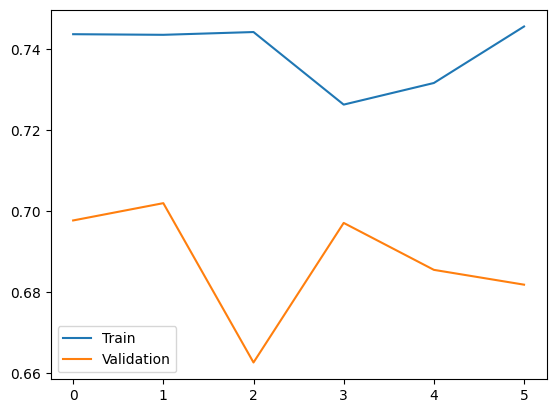

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train','Validation'])
plt.show()

In [2]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("audio_emotion_model.h5")

# Load emotion order
emotion_labels = np.load("audio_emotion_order.npy", allow_pickle=True)
emotion_labels = [str(e) for e in emotion_labels]

print("Emotion order:", emotion_labels)

Emotion order: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'surprised']


In [41]:
def predict_audio_emotion(file_path):
    data, sr = librosa.load(file_path, duration=3, offset=0.5)
    feat = extract_features(data,sr)
    feat = np.expand_dims(feat,axis=(0,-1))

    probs = model.predict(feat,verbose=0)[0]

    return {emotion:round(float(prob),3)
            for emotion,prob in zip(emotion_labels,probs)}


In [42]:
# predict_audio_emotion("1001_DFA_ANG_XX.wav")
# predict_audio_emotion("1001_IOM_SAD_XX.wav")
# predict_audio_emotion("OAF_back_sad.wav")
# predict_audio_emotion("1001_DFA_FEA_XX.wav")
# predict_audio_emotion("YAF_back_disgust.wav")
# predict_audio_emotion("sad-ajp-1.wav")
predict_audio_emotion("fear-ajp.wav")





{'angry': 0.099,
 'calm': 0.007,
 'disgust': 0.244,
 'fear': 0.038,
 'happy': 0.126,
 'neutral': 0.337,
 'sad': 0.122,
 'surprise': 0.027,
 'surprised': 0.0}

In [43]:
model.save("audio_emotion_model.h5")
np.save("audio_emotion_order.npy",emotion_labels)
